# Problem 1
In this problem, we will generate bivariate data from two normal distributions and classify the data using logistic regression. `runTest.m` executes the main part of the program and calls `modelFitVal.m` to fit and cross-validate the model. We will visualize the underlying distributions and the resulting decision boundary.

In [42]:
# load packages
%pylab inline
from scipy.stats import multivariate_normal
import statsmodels.api as sm
from modelFitVal_solution import modelFitVal

Populating the interactive namespace from numpy and matplotlib


/home/mome/venv3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['multivariate_normal']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Part 1: Sampling and Analyzing
`runTest.m` begins by specifying the parameters for generating the data: sample size, means, and covariance matrix.


In [ ]:
# set sample size, means, and covariance matrix
nSamples = 500
mu_1 = [1, 3]
mu_2 = [3, 0]
sigma = [[ 2.0,  1.5],
         [ 1.5,  2.0]]

First, we generate the data using these parameters and an appropriate function, concatenate the two
sample populations, and create a vector of labels (ones for one population, zeros for the other)

In [ ]:
# create distributions
dist1 = multivariate_normal(mu_1, sigma)
dist2 = multivariate_normal(mu_2, sigma)

# sample data from both distributions and create labels
X1 = dist1.rvs(nSamples)
X2 = dist2.rvs(nSamples)
X = vstack([X1, X2])
L = hstack([ones(nSamples), zeros(nSamples)]) #.reshape(-1,1)

$n$ is the number of samples, $X$ will be a $2n\times 2$ matrix and $L$ will be of length $2n$.
Next, we want to see what the two underlying distributions look like along the two dimensions $x_1$
and $x_2$ (not to be confused with the two sample populations $X_1$ and $X_2$). Create a grid of $100\times100$
equidistant points within the bounds of the sample populations, using xVector, and compute the two
PDFs for each point.

In [ ]:
# compute representative densities of underlying distributions
xVector = linspace(X.min(), X.max(), 100)
xx = transpose([tile(xVector, 100), repeat(xVector, 100)])
pDist = dist1.pdf(xx) + dist2.pdf(xx)
pDist = pDist.reshape(100, 100)

You might want to use the `meshgrid` function and reshape the resulting matrices to vectors. If you have trouble with the suggested one-liners, use for-loops instead. The result `pDist` should be a 100$\times$100 matrix containing the sum of both PDFs.

Now we train a generalized linear model on the sample data. Look into the MATLAB documentation for `glmfit` to find the right arguments for the distribution and link function.

In [ ]:
# fit GLM using logistic regression
X = sm.add_constant(X)
model = sm.GLM(L, X, family=sm.families.Binomial())
model_fit = model.fit()

The result `coeff` will be a vector of 3 coefficients.

To display the decision boundary of the fitted model, we solve the iso-error problem, i.e. we compute the line on which $P(C_1\ |\ x) = P(C_2\ |\ x) = 0.5$. This means solving
$$0.5 = \sigma (w^Tx+w_0)$$
with $\sigma$ being the logistic function; $w=(w_1,w_2)$; $w_0$, $w_1$ and $w_2$ given by `coeff`; and $x=(x_1,x_2)$. We have to rewrite the equation for $x_2$ and set $x_1$ to `xVector`.

In [ ]:
# determine the decision boundary of the fitted model
c1, c2, c3 = model_fit.params
x2db = (-log(0.5) - c2*xVector - c1) / c3

Now we validate the fitted model (find the appropriate function!) on the same 100$\times$100 data points as before to get the posterior densities predicted by the model. (We only compute $P(C_1\ |\ x)$, since $P(C_2\ |\ x)=1-P(C_1\ |\ x)$.)

In [ ]:
# compute representative class posteriors
posterior_C1 = model_fit.predict(sm.add_constant(xx))
posterior_C1 = posterior_C1.reshape(100, 100)

Finally, we want to again train and 10-fold cross-validate the model, using our own function.

In [ ]:
# cross-validate the same model to estimate generalization
kCross = 10
pCorrect = modelFitVal(X, L, kCross)

The remainder of runTest.m is about plotting and doesn’t need to be edited.


Performance: 99.0 percent




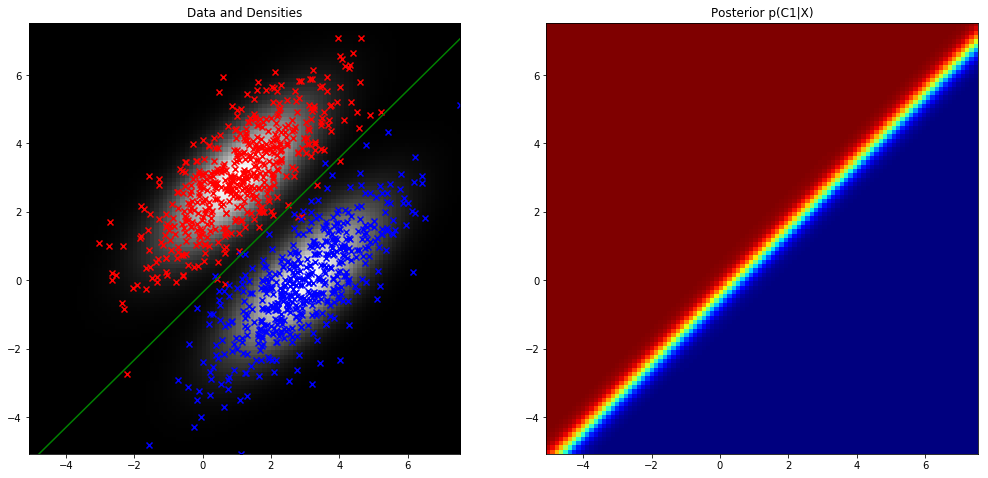

In [41]:
# plot data, distributions, and decision boundary
figure(figsize=[17,8])
subplot(121)
imshow(rot90(pDist.T), extent=(X.min(), X.max())*2, cmap='gray')
scatter(*X1.T, color='red', marker='x')
scatter(*X2.T, color='blue', marker='x')
plot(xVector, x2db, color='green')
ylim((X.min(), X.max()))
xlim((X.min(), X.max()))
title('Data and Densities')

# plot posterior C1
subplot(122)
imshow(rot90(posterior_C1.T), extent=(X.min(), X.max())*2, cmap='jet')
ylim(X.min(), X.max()); xlim(X.min(), X.max())
title('Posterior p(C1|X)')

# print performance
print('\nPerformance: %s percent\n\n' % round(100*pCorrect))

# Part 2: Classification
The function `modelFitVal.m` should take a data matrix (samples$\times$dimensions), a correpsonding label vector, and the number of partitions, then iteratively divide the data and labels into training sets and test sets, fit and validate the GLM, and return the mean percentage of correctly predicted labels.

First, we create a random permutation of the sample indices, which we will use when composing the partitions.

```python
nSamples = size(X, 1);
randIdx = ...
```

This way we avoid order effects on model performance but still create disjoint partitions. With our random data, order doesn't matter, but will in the later problems.

In the subsequent loop we divide the data and labels into test and training sets. From \texttt{randIdx} we select $\frac{\texttt{nSamples}}{\texttt{k}}$ indices for testing and the remaining $\frac{(\texttt{k}-1)\texttt{nSamples}}{\texttt{k}}$ indices for training.

```python
pCorrect = 0;
for iPart=1:k
    idxTest = ...
    idxTrain = ...
    xTest = X(...);
    xTrain = X(...);
    lTest = L(...);
    lTrain = L(...);
```

Note that \texttt{nSamples} need not be a multiple of \texttt{k}. Make sure that the size of test sets (same for training sets) does not differ by more than 1 across partitions. Make also sure that all samples are used for testing exactly once.

Now we fit the logit model as before and compare the rounded validation output, i.e. the predicted labels for the test data, to the actual labels. The percentage of correct predictions is then accumulated over iterations.

```python
    coeff = glmfit(...);
    lPredicted = round(...);
    pCorrect = pCorrect + 1/k*mean(lPredicted==lTest);
end
```

## Part 3: Plotting and Exploring
Your code should print the model's average classification performance and produce the two figures below, showing the sample data with their underlying distributions and the model's decision boundary, and the class posterior probabilities, respectively.

$ $ | $ $
- | -
![p1fig1](p1fig1.png) | ![p1fig2](p1fig2.png)


Note that the plots will vary a bit at between runs because of the randomness in sampling and cross-validation. Classification performance should be at or near 100%. You may want to try different distribution parameters and sample sizes and see how performance and plots change. Try to understand the warning messages you might get.